In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ubuntu/varios/skforecast'

In [2]:

# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import bayesian_search_forecaster
from sklearn.metrics import mean_squared_error

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00 (n=29)


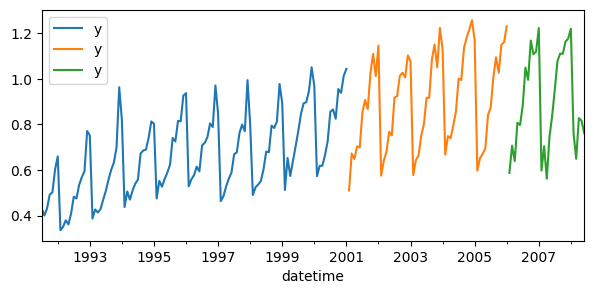

In [3]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-val-test dates
# ==============================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}"
    f"  (n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}"
    f" (n={len(data.loc[end_val:])})"
)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

In [4]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 4 # Placeholder, the value will be overwritten
             )

def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-11:-1]     # window_size = 10
    mean = np.mean(y[-20:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors

forecaster = ForecasterAutoregCustom(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_predictors,
                 name_predictors = [f'lag {i}' for i in range(1, 11)] + ['moving_avg_20'],
                 window_size     = 20 # window_size needed by the mean is the most restrictive one
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'     : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'     : trial.suggest_categorical('max_features', ['log2', 'sqrt']),
        'lags'             : trial.suggest_categorical('lags', [3, 5])
    } 
    return search_space

results, frozen_trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = data.loc[:end_val, 'y'],
                            lags_grid             = lags_grid,
                            search_space          = search_space,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = False,
                            initial_train_size    = len(data.loc[:end_train]),
                            fixed_train_size      = True,
                            n_trials              = 10,
                            random_state          = 123,
                            return_best           = True,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {},
                            output_file = 'results.csv'
                        )

results.head(4)

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1310: UserWarning: The 'lags_grid' argument is deprecated and will be removed in a future version. Use the 'search_space' argument to define the candidate values for the lags. Example: {'lags' : trial.suggest_categorical('lags', [3, 5])}
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-02-08 10:20:15,280] Trial 0 finished with value: 0.18547840371008792 and parameters: {'n_estimators': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'lags': 3}. Best is trial 0 with value: 0.18547840371008792.
[I 2024-02-08 10:20:15,430] Trial 1 finished with value: 0.21310096923415872 and parameters: {'n_estimators': 20, 'min_samples_leaf': 7, 'max_features': 'log2', 'lags': 5}. Best is trial 0 with value: 0.18547840371008792.
[I 2024-02-08 10:20:15,574] Trial 2 finished with value: 0.17229123946428576 and parameters: {'n_estimators': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'lags': 3}. Best is trial 2 with value: 0.17229123946428576.
[I 2024-02-08 10:20:15,697] Trial 3 finished with value: 0.19576549770891777 and parameters: {'n_estimators': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'lags': 3}. Best is trial 2 with value: 0.17229123946428576.
[I 2024-02-08 10:20:15,844] Trial 4 finished with value: 0.1750792120695714 and parameters: {'n_estimators': 17,

,lags,params,mean_absolute_error,n_estimators,min_samples_leaf,max_features
9,custom function: create_predictors,"{'n_estimators': 13, 'min_samples_leaf': 4, 'm...",0.168282,13,4,sqrt
2,custom function: create_predictors,"{'n_estimators': 14, 'min_samples_leaf': 1, 'm...",0.172291,14,1,sqrt
4,custom function: create_predictors,"{'n_estimators': 17, 'min_samples_leaf': 4, 'm...",0.175079,17,4,log2
0,custom function: create_predictors,"{'n_estimators': 17, 'min_samples_leaf': 3, 'm...",0.185478,17,3,sqrt


# Experiment 1

In [5]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.datasets import fetch_dataset
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset


In [6]:
# Downloading data
# ==============================================================================
data = fetch_dataset('bike_sharing_extended_features', raw=False)

bike_sharing_extended_features
------------------------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, the dataset
was enriched by introducing supplementary features. Addition includes calendar-
based variables (day of the week, hour of the day, month, etc.), indicators for
sunlight, incorporation of rolling temperature averages, and the creation of
polynomial features generated from variable pairs. All cyclic variables are
encoded using sine and cosine functions to ensure accurate representation.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17352, 90)


In [7]:
# Select exogenous variables to be included in the model
# ==============================================================================
df_exogenous_features = data.drop(columns=['users'])
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(df_exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
# columns that start with temp_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^temp_.*').columns.tolist())
# Columns that start with holiday_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^holiday_.*').columns.tolist())
exog_features.extend(['temp', 'holiday'])

df_exogenous_features = df_exogenous_features.filter(exog_features, axis=1)
df_exogenous_features['dummy_variable'] = 1

In [8]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 4 # Placeholder, the value will be overwritten
             )

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]])
    } 
    return search_space

results, frozen_trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = data['users'],
                            exog                  = df_exogenous_features,
                            search_space          = search_space,
                            steps                 = 36,
                            metric                = 'mean_absolute_error',
                            refit                 = False,
                            initial_train_size    = int(len(data)*0.7),
                            fixed_train_size      = True,
                            n_trials              = 20,
                            random_state          = 123,
                            return_best           = True,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {},
                            output_file = 'results.csv'
                        )

results.head(4)

/home/ubuntu/anaconda3/envs/skforecast_12_py12/lib/python3.12/site-packages/tqdm/std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))


  0%|          | 0/20 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/skforecast_12_py12/lib/python3.12/site-packages/tqdm/std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))


[I 2024-02-08 10:20:25,630] Trial 0 finished with value: 67.90552342088279 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.12115721224645952, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.7000000000000001, 'lags': 72}. Best is trial 0 with value: 67.90552342088279.
[I 2024-02-08 10:20:30,469] Trial 1 finished with value: 66.33261812226344 and parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.17815722791392602, 'reg_alpha': 0.8, 'reg_lambda': 0.4, 'lags': [1, 2, 3, 23, 24, 25, 167, 168, 169]}. Best is trial 1 with value: 66.33261812226344.
[I 2024-02-08 10:20:33,746] Trial 2 finished with value: 73.37033338395582 and parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2704601731825008, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001, 'lags': 48}. Best is trial 1 with value: 66.33261812226344.
[I 2024-02-08 10:20:47,098] Trial 3 finished with value: 69.91138184118908 and parameters: {'n_estimators': 1000, 'max_depth': 5,

KeyboardInterrupt: 